In [12]:
using Plots
using FFTW
using StatsBase
using DSP
using LinearAlgebra
pyplot()

# Common Data Elements
steps = 1*10^6
discard = 10^3
steps_tot = steps + discard

Nex = 2^10;
Theta = 2pi*(0:Nex-1)/(Nex);
Z = map(th -> exp(im*th),Theta);

In [57]:
function z_crossspect(sig,pred,L; win = "Par")
    lags = -L:L;
    C = crosscov(sig,pred,lags)
    if win == "Bar"
        lam = 1 .- (0:L)/L
    elseif win == "Tuk"
        lam = .5*(1 .+ cos.(pi/L*(0:L)))
    elseif win == "Par"
        LL = Int(floor(L/2))
        lam1 = 1 .- 6*((0:LL)/L).^2 .+ 6*((0:LL)/L).^3
        lam2 = 2*(1 .- (LL+1:L)/L).^3
        lam = [lam1; lam2]
    else
        lam = ones(L+1)
    end

    z_crossspect_num(z) = sum([lam[abs(i) + 1]*C[L+1+i]*z^(-i) for i = -L : L])
end

z_crossspect (generic function with 1 method)

In [62]:
function z_crossspect_fft(sig,pred,L,Nex; win = "Par")
    L = 120

    Nexh = Int(floor(Nex/2))

    lags = -L:L;
    c = crosscov(sig,pred,lags)
    if win == "Bar"
        lam = 1 .- (0:L)/L
    elseif win == "Tuk"
        lam = .5*(1 .+ cos.(pi/L*(0:L)))
    elseif win == "Par"
        LL = Int(floor(L/2))
        lam1 = 1 .- 6*((0:LL)/L).^2 .+ 6*((0:LL)/L).^3
        lam2 = 2*(1 .- (LL+1:L)/L).^3
        lam = [lam1; lam2]
    else
        lam = ones(L+1)
    end

    Lam = [lam[L+1:-1:2]; lam]

    C_smooth = Lam .* c

    C_pad = [zeros(Nex - Nexh - L); C_smooth ; zeros(Nexh - L -1)]
    C = fftshift(C_pad);

    z_crossspect_num_fft = fftshift(fft(C_pad))
end

z_crossspect_fft (generic function with 1 method)

# Tests

The first test will be on a MA(1) process.
$$y_n = u_n - ru_{n-1}$$
with $x_n = y_n + v_n$.

The analytic $z$-cross-spectrum is 

## Data 

### MA(1)

In [58]:
r = 10
sig_v = 10
par = 30

noise_sig = randn(steps_tot)
w = [1, -r];
sig = conv(w,noise_sig)[discard + 1 : steps_tot];

noise_pred = sig_v*randn(steps)
pred = sig .+ noise_pred;

z_crossspect_sigpred_num = z_crossspect(sig, pred, par, win = "Par");

z_crossspect_sigpred_num_fft = z_crossspect_fft(sig, pred, par, Nex, win = "Par");

z_crossspect_sigpred_ana(z) = (1 - r*z^(-1))*(1 - r*z);

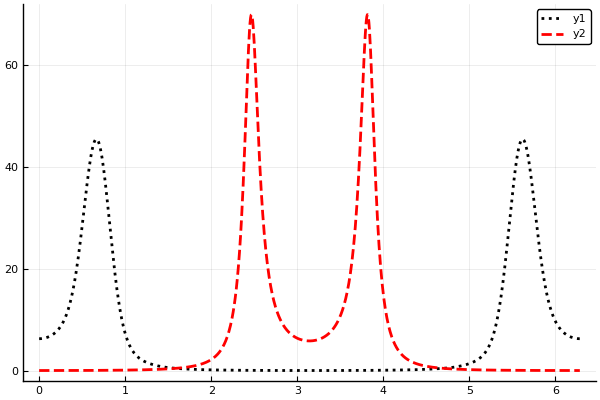

In [55]:
plot(Theta,([abs.(z_crossspect_sigpred_ana.(Z)) abs.(z_crossspect_sigpred_num.(Z)) abs.(z_crossspect_sigpred_num_fft)]),
    color = [:red :black :gray],
    line = ([:solid :dot :dash],2)
    label=["sig_hat_ana" "sig_hat_ana" "sig"])
)

### AR(2)

In [59]:
r, t = .9, 81

# each need modulus less than one for the process to be stationary. 
# Also for the process to be rea-valued r1 and r2 are either real or complex conjugates
r1, r2 = r*exp(im*t), r*exp(-im*t) 
sig_v = 1
M_h = 50

l = [1, -(r1 + r2), r1*r2];

noise_sig = randn(steps_tot)
sig = zeros(steps_tot);

sig[1:2] = noise_sig[1:2];
for i = 3 : steps_tot
    sig[i] = dot(-reverse(l)[1:2],sig[i - 2:i-1]) + noise_sig[i]
end
sig = sig[discard + 1 : steps_tot];

noise_pred = sig_v*randn(steps)
pred = sig .+ noise_pred;

In [60]:
z_crossspect_sigpred_num = z_crossspect(sig, pred, par, win = "Par");

z_crossspect_sigpred_ana(z) = ( (1+r1*z^(-1))*(1+r2*z^(-1))*(1+conj(r1)*z)*(1+conj(r2)*z) )^(-1);

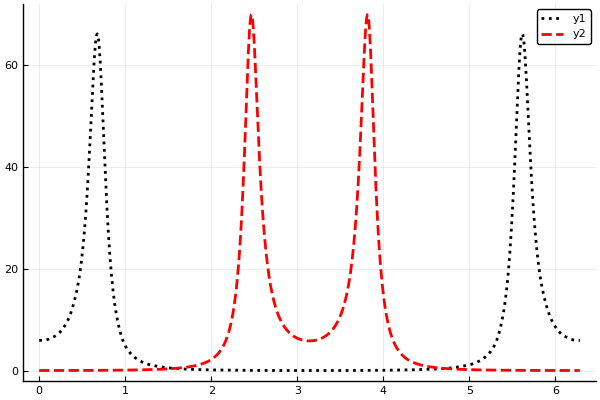

In [61]:
plot(Theta,([abs.(z_crossspect_num_fft) abs.(z_crossspect_sigpred_ana.(Z))]),
    color = [:black :red],
    line = ([:dot :dash],2))

In [ ]:
S(z) = 9 + 1.3*z + 1.3*z^(-1);

c = [1.3, 9, 1.3 ]
c_pad = [zeros(Nex - Nexh -1); c; zeros(Nexh -2)]

In [46]:
c_pad[513]

9.0

In [40]:
S_fft = fft(fftshift(c_pad));

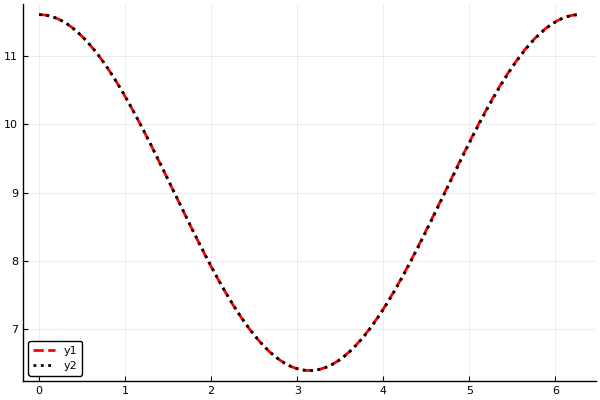

In [45]:
plot(Theta,([real.(S.(Z)) real.(S_fft)]),
    color = [:red :black],
    line = ([:dash :dot] ,2))